# `peak_minimization.ipynb`
This file is to test the hypothesis of using peaks to minimize $||(I-HH^+)b||$. Once it is working, it should be added to `WSN.py` under `localize_min_peaks`.

Liberties (assumptions) taken:
* For now, I am assuming I know the speed to be `c=1.6424885622140555`. After I get this working, I will work on an algorithm for estimating this speed. I use the speed estimate to eliminate peaks which are too far from 0 to be possible.
* Sometimes, nodes are so close together that limiting the positions of the peaks makes it impossible to see the peak (since such a small amount of it is seen). So, I extend the max_tau by adding a small amount. I am assuming that I know that this amount should be about <b>20 time steps</b>, since I know that the period is about <b>100 time steps</b>. In the future, the period will have to be estimated to know how much of the peak needs to be seen in order to detect it.
* I am putting a minimum on the height of peaks to be considered, since there are small peaks which do not tell us about the time shift. I say that the peak must be at least `inclusion_factor *` the height of the tallest peak. Right now, `inclusion_factor = 0.6`.

Other notes:
* With a node space size of 100x100 and a speed of `c=1.6424885622140555`, it would take ~60s for the the signal to propagate from one side to the other or ~85s for it to propagate from one corner to the other. I remove the first 400 time steps (or 40s) from the signal to allow the first wave time to arrive, so the original parameter, `T` of `mtin.default_fn_equ_params`, which was `1000` or 100s, will not work. Therefore, I changed `T` to `2000` in `mutual_information.py`.

In [2]:
from WSN import *
import mutual_information as mtin
from scipy.signal import find_peaks
from color import *

In [3]:
mtin.solve_default_fn_equ()

Stats to find:
* With the list of results sorted by output accuracy, 
    * how high on the list do the correct peaks land?
    * how high on the list does the highest result when sorted by lse land?
    * how often does the highest result correspond to the correct peaks?
* With the list of results sorted by lse,
    * how high on the list do the correct peaks land?
    * how often does the highest result correspond to the correct peaks?
    * what is the output accuracy (distance and speed squared) of the highest result
        * when it is the correct peaks?
        * when it is not the correct peaks?
        * on average?
* How many combinations of peaks were there on average?

In [4]:
# Generate signals and find all peaks
def get_all_fn_peaks(self, r0=None):
    if r0 is None:
        r0 = np.array([55, 55])
    results = self.transmit_continuous(signal_type="fn")
    assert np.all(np.array([result[0] for result in results]) == self.nodes)

    all_peaks = [] # [(rn, rm, p, array([p1, p2, p3])), ...]

    for _, i, j in self.find_MST():
        ri, sigi = results[i]
        rj, sigj = results[j]
        dt = 0.1
        max_delay = dist(ri, rj) / self.c
        max_tau = int(max_delay / dt) + 20
        shifts = np.arange(-max_tau, max_tau, 1)
        mis = mtin.mi_shift(np.transpose([sigi, sigj]), shifts)

        max_peak = max(mis)
        inclusion_factor = 0.6
        peaks, _ = find_peaks(mis, height=max_peak * inclusion_factor)
        peaks = shifts[peaks] * dt

        p = (dist(ri, r0) - dist(rj, r0)) / c
        all_peaks.append((ri, rj, p, peaks))
    return all_peaks


In [5]:
# Find outputs for every peaks in all_peaks
def get_peaks_outputs(self, all_peaks, r0=None):
    if r0 is None:
        r0 = np.array([55, 55])
    
    nodes = [tuple(node) for node in self.nodes]
    tree_dict = {node: [] for node in nodes}
    for rn, rm, _, _ in all_peaks:
        tree_dict[tuple(rn)].append(tuple(rm))
        tree_dict[tuple(rm)].append(tuple(rn))
    r1 = nodes[0]

    output = []

    pinds = [0] * len(all_peaks)
    d = 0
    while True:
        # Get H and b
        peaks_dict = {(tuple(rn), tuple(rm)): (i, p, peaks) for i, (rn, rm, p, peaks) in enumerate(all_peaks)}

        delays = {r1: 0}
        def get_child_delays(root):
            children = tree_dict[root]
            for child in children:
                if child in delays:
                    continue

                if (root, child) in peaks_dict:
                    i, p, peaks = peaks_dict[(root, child)]
                    p = -p
                    peaks = -peaks
                else:
                    i, p, peaks = peaks_dict[(child, root)]
                peak = peaks[pinds[i]] if d != 0 else p
                delays[child] = delays[root] + peak
                get_child_delays(child)
        get_child_delays(r1)

        Hb = [
            self.get_mTDOA_H_and_b_row(
                (np.array(rn), delays[tuple(rm)] + (peaks[pinds[i]]) if d != 0 else p),
                (np.array(rm), delays[tuple(rm)])
            )
            for i, (rn, rm, p, peaks) in enumerate(all_peaks)
        ]
        H = np.zeros((len(Hb), 4))
        b = np.zeros(len(Hb))

        # Hb = [(Hrow0, b0), (Hrow1, b1), ...]
        # H = [Hrow0, Hrow1, ...]
        # b = [b0, b1, ...]
        # This line unpacks the tuples from Hb into H and b
        [0 for i, (H[i], b[i]) in enumerate(Hb)]

        # Calculate position
        Hpinv = np.linalg.pinv(H)
        x = Hpinv @ b
        est_pos = x[:2]
        c2 = x[3]

        # Calculate error
        least_squared = (np.eye(len(b)) - H @ Hpinv) @ b
        lse = np.dot(least_squared, least_squared)

        distance_err = dist(est_pos, r0)
        speed_squared_err = np.abs(c2 - self.c ** 2)

        # Add position and error to output matrix
        output.append((
            lse,
            distance_err,
            speed_squared_err,
            tuple(pinds) if d != 0 else [-1] * len(pinds),
            [all_peaks[i][3][pind] for i, pind in enumerate(pinds)] if d != 0 else [p for _, _, p, _ in all_peaks],
            x
        ))


        # Increment peak indices
        # If finished, break
        if d != 0:
            for b in range(len(pinds)):
                pinds[b] += 1
                if pinds[b] >= len(all_peaks[b][3]):
                    pinds[b] = 0
                else:
                    break
            else:
                break
        d += 1
    real_peaks = output[0]
    output.pop(0)
    return real_peaks, output

def find_most_realistic_peaks(self, output, real_peaks):
    return min(output, key=lambda x: np.sum(np.abs(np.array(x[4]) - np.array(real_peaks[4]))))


Format of `errs`:
    `[(lse, distance_err, speed_squared_err, pinds, array([p1, p2, p3]), x), ...]`

In [6]:
# Create the WSN and find the MST
N = 7
c = 1.6424885622140555
r0 = np.array([55, 55])
wsn = WSN(100, N, std=0, D=142, c=c, verbose=False)
wsn.reset_nodes()
wsn.reset_anchors(range(N))
# MST = wsn.find_MST()


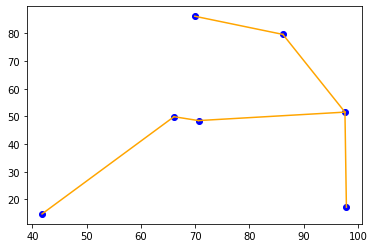

In [24]:
# Visualization of nodes
[plt.plot(*np.transpose([wsn.nodes[i], wsn.nodes[j]]), c="orange") for _, i, j in wsn.find_MST()]
plt.scatter(wsn.nodes[:, 0], wsn.nodes[:, 1], c="blue")
plt.show()

In [7]:
LSE, DISTANCE_ERR, SPEED_SQUARED_ERR, PINDS, PEAKS, X = range(6)

In [8]:
[setattr(WSN, attr, globals()[attr]) for attr in (
    "get_all_fn_peaks",
    "get_peaks_outputs",
    "find_most_realistic_peaks"
)]

[None, None, None]

In [30]:
iterations = 1000

# With the list of results sorted by accuracy,
#   how high on the list do the correct peaks land?
acc__correct_index_avg = 0
#   how high on the list does the highest result when sorted by lse land?
acc__lse_output_index_avg = 0
#   how often does the highest result correspond to the correct peaks?
acc__correct_index_eq_0_total = 0

# With the list of results sorted by lse,
#   how high on the list do the correct peaks land?
lse__correct_index_avg = 0
#   how often does the highest result correspond to the correct peaks?
lse__correct_index_eq_0_total = 0
#   what is the output accuracy (distance and speed squared) of the highest result
#       when it is the correct peaks?
lse__dist_acc_correct_index_eq_0_avg = 0
lse__spsq_acc_correct_index_eq_0_avg = 0
#       when it is not the correct peaks?
lse__dist_acc_correct_index_ne_0_avg = 0
lse__spsq_acc_correct_index_ne_0_avg = 0
#       on average
lse__dist_acc_avg = 0
lse__spsq_acc_avg = 0

# How many combinations of peaks were there on average?
len_output = 0


In [31]:
for it in tqdm(range(iterations)):
    wsn.reset_nodes()
    all_peaks = wsn.get_all_fn_peaks()
    real_peaks, output = wsn.get_peaks_outputs(all_peaks)
    len_output += len(output)
    most_realistic_peaks = wsn.find_most_realistic_peaks(output, real_peaks)
    output: list
    
    # Sort by lse
    output.sort(key=lambda x: x[LSE])

    lse__correct_index = output.index(most_realistic_peaks)
    lse__correct_index_avg += lse__correct_index
    lse_output = output[0]
    if lse__correct_index == 0:
        lse__correct_index_eq_0_total += 1
        lse__dist_acc_correct_index_eq_0_avg += lse_output[DISTANCE_ERR]
        lse__spsq_acc_correct_index_eq_0_avg += lse_output[SPEED_SQUARED_ERR]
    else:
        lse__dist_acc_correct_index_ne_0_avg += lse_output[DISTANCE_ERR]
        lse__spsq_acc_correct_index_ne_0_avg += lse_output[SPEED_SQUARED_ERR]
    lse__dist_acc_avg += lse_output[DISTANCE_ERR]
    lse__spsq_acc_avg += lse_output[SPEED_SQUARED_ERR]

    # Sort by accuracy
    output.sort(key=lambda x: x[DISTANCE_ERR])
    acc__correct_index = output.index(most_realistic_peaks)
    acc__correct_index_avg += acc__correct_index
    if acc__correct_index == 0:
        acc__correct_index_eq_0_total += 1
    acc__lse_output_index = output.index(lse_output)
    acc__lse_output_index_avg += acc__lse_output_index
    

acc__correct_index_avg /= iterations
acc__lse_output_index_avg /= iterations
acc__correct_index_eq_0_total
lse__correct_index_avg /= iterations
lse__correct_index_eq_0_total
lse__dist_acc_correct_index_eq_0_avg /= lse__correct_index_eq_0_total
lse__spsq_acc_correct_index_eq_0_avg /= lse__correct_index_eq_0_total
lse__dist_acc_correct_index_ne_0_avg /= (iterations - lse__correct_index_eq_0_total)
lse__spsq_acc_correct_index_ne_0_avg /= (iterations - lse__correct_index_eq_0_total)
lse__dist_acc_avg /= iterations
lse__spsq_acc_avg /= iterations
len_output /= iterations


  8%|▊         | 84/1000 [00:44<06:32,  2.33it/s]d:\Repositories\WSN-Localization\mutual_information.py:105: RuntimeWarning: divide by zero encountered in log
  mi = -0.5 * np.log(np.linalg.det(cor))
 92%|█████████▏| 917/1000 [08:05<00:54,  1.51it/s]d:\Repositories\WSN-Localization\mutual_information.py:105: RuntimeWarning: invalid value encountered in log
  mi = -0.5 * np.log(np.linalg.det(cor))
100%|██████████| 1000/1000 [08:48<00:00,  1.89it/s]


In [35]:
# Report findings
print(f"On average, there were \n    {round(len_output, 2)} combinations of peaks to choose from.")
print()
print("====When sorted by output accuracy====")
print(f"The correct set of peaks was the \n    {round(acc__correct_index_avg, 2)}th most accurate on average.")
print(f"The lse output peaks were the \n    {round(acc__lse_output_index_avg, 2)}th most accurate on average.")
print(f"Out of the {iterations} cases, the correct peaks were the most accurate in \n    {acc__correct_index_eq_0_total} of them.")
print()
print("====When sorted by lse accuracy===")
print(f"The correct set of peaks had the \n    {round(lse__correct_index_avg, 2)}th lowest lse, ||(I-HH+)b||.")
print(f"Out of the {iterations} cases, the lse output peaks were the correct peaks in \n    {lse__correct_index_eq_0_total} of them.")
print(f"When the lse output peaks were correct, the estimated position was \n    {round(lse__dist_acc_correct_index_eq_0_avg, 2)} m away from the target node on average.")
print(f"When the lse output peaks were correct, the estimated speed squared was \n    {round(lse__spsq_acc_correct_index_eq_0_avg, 2)} m^2/s^2 away from the true speed squared of 2.697768677003995 m^2/s^2 on average.")
print(f"When the lse output peaks were not correct, the estimated position was \n    {round(lse__dist_acc_correct_index_ne_0_avg, 2)} m away from the target node on average.")
print(f"When the lse output peaks were not correct, the estimated speed squared was \n    {round(lse__spsq_acc_correct_index_ne_0_avg, 2)} m^2/s^2 away from the true speed squared of 2.697768677003995 m^2/s^2 on average.")
print(f"On average, the estimated position was \n    {round(lse__dist_acc_avg, 2)} m away from the target node.")
print(f"On average, the estimated speed squared was \n    {round(lse__spsq_acc_avg, 2)} m^2/s^2 away from the true speed squared of 2.697768677003995 m^2/s^2.")


On average, there were 
    295.49 combinations of peaks to choose from.

====When sorted by output accuracy====
The correct set of peaks was the 
    22.27th most accurate on average.
The lse ouptut peaks were the 
    149.78th most accurate on average.
Out of the 1000 cases, the correct peaks were the most acurate in 
    290 of them.

====When sorted by lse accuracy===
The correct set of peaks had the 
    20.21th lowest lse, ||(I-HH+)b||.
Out of the 1000 cases, the lse output peaks were the correct peaks in 
    153 of them.
When the lse output peaks were correct, the estimated position was 
    2.9 m away from the target node on average.
When the lse output peaks were correct, the estimated speed squared was 
    1.83 m^2/s^2 away from the true speed squared of 2.697768677003995 m^2/s^2 on average.
When the lse output peaks were not correct, the estimated position was 
    24.66 m away from the target node on average.
When the lse output peaks were not correct, the estimated speed

Single test visualization: This method may just err toward the COM again. I guess putting $r_0$ at the COM and finding peaks which match that guess satisfies the equation well.

In [152]:
wsn.reset_nodes()
wsn.nodes = np.random.uniform(0, 50, size=(wsn.N, 2))
# wsn.nodes[-1] = np.random.uniform(50, 100, size=2)

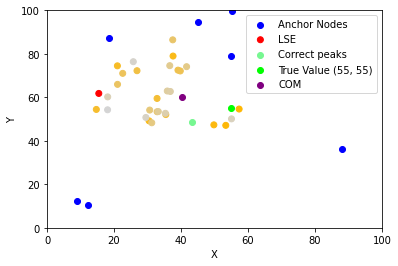

In [10]:
# Visualize accuracy
all_peaks = wsn.get_all_fn_peaks()
real_peaks, output = wsn.get_peaks_outputs(all_peaks)
output.sort(key=lambda x: x[SPEED_SQUARED_ERR])
most_realistic_peaks = wsn.find_most_realistic_peaks(output, real_peaks)
est_poss = [out[X][:2] for out in output[:30]]
est_poss = np.array(est_poss)
mean = np.mean(wsn.nodes, axis=0)

plt.scatter(*wsn.nodes.T, c="blue", label="Anchor Nodes")
plt.scatter(*est_poss.T, c=["#ff0000"] + [interpolate_color("#ffb700", "#d4d4d4", alpha).get_hex() for alpha in np.linspace(0, 1, len(est_poss) - 1)], label="LSE")
plt.scatter(*most_realistic_peaks[X][:2], c=["#77f791"], label="Correct peaks")
plt.scatter(55, 55, c="#00ff00", label="True Value (55, 55)")
plt.scatter(*mean, c="purple", label="COM")
plt.xlim((0, 100))
plt.ylim((0, 100))
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


In [12]:
output[0]

(832322.0722732712,
 40.13006664984199,
 0.12043560777633866,
 (1, 0, 1, 0, 1, 1),
 [-20.5, 2.0, 17.3, 0.8, 19.200000000000003, 1.7000000000000002],
 array([ 15.44939241,  61.79497523, -70.8633618 ,   2.81820428]))